In [11]:
# refresh imports
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts

# set default plot size as large
plt.rcParams['figure.figsize'] = [20, 10]




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import pandas as pd
import sqlite3
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1



In [13]:
def plot_results(df_results):
    for target_name in df_results.target_name.unique():
        df_results_ = df_results[df_results.target_name == target_name]
        for model_name  in df_results_.model_name.unique():
            # plot scores
            plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

        # set x ticks as size   
        plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
        plt.title(target_name)
        plt.ylabel('score')
        plt.xlabel('Encoder-Decoder compression size')
        plt.ylim(0,1.1)
        plt.legend()
        plt.show()

activation = {}

def get_activations(model, df):
    activation_list = []

    for idx, row in tqdm(df.iterrows()):

        data = transform([row['fen']]).cuda()
        output = model(data)

        activations_ = {'index': idx}
        for k, v in activation.items():
            values = v.cpu().numpy()[0]
            if 0:
                if k in ['input_encoder_0',]:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values, dtype=bool)
                elif k in ['decoder_3']:
                    # convert values to csr matrix with boolean values
                    values = csr_matrix(values > 0, dtype=bool)
                else:
                    # convert values to numpy float16
                    values = values.astype(np.float16)
            if k in ['decoder_3']:
                values = expit(values)
            else:
                values = values.astype(np.float16)
            
            activations_[k] = values


        # copy activation and add to activation_list
        activation_list.append(activations_.copy())

    df_activations = pd.DataFrame(activation_list)
    return df_activations


def train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = 0):
    results = []
    for concept_model in concept_models:
        for input_name in input_names:
            for target_name in target_names:

                model_name = f"{concept_model.__class__.__name__}"

                X = df_activations[input_name].tolist()
                y = df[target_name].tolist()
                print(f"X: {input_name}, y: {target_name}, model_name: .{model_name}")

                # if X is scipy.sparse.csr_matrix, vstack it 
                if isinstance(X[0], csr_matrix):
                    X = vstack(X).astype(np.float32)
                    size = X.shape[1]
                else:
                    size = len(X[0])

                # change type of y to int
                y = np.array(y).astype(int)

                if target_name == 'white_queen':
                    # is y larger than 0
                    y = y > 0

                # fit and apply the transform
                X, y = undersample.fit_resample(X, y)


                # split into train and test sets 
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=test_size, random_state=42, stratify=y
                )



                concept_model.fit(X_train, list(y_train))
                y_pred = concept_model.predict(X_test)

                score = metric(y_test, y_pred)

                # calculate confusion matrix
                matrix = confusion_matrix(y_test, y_pred)

                if verbose:
                    print(f'Target value counts: {pd.Series(y_train).value_counts()}')
                    print(f'Target value counts: {pd.Series(y_test).value_counts()}')
                    print(f'input shape: {size}')
                    print(matrix)
                    print(score)

                results_ = {'model_name': model_name,
                            'input_name': input_name, 
                            'target_name': target_name,
                            'score': score, 
                            'size': size}
                results.append(results_)

    df_results = pd.DataFrame(results)
    return df_results



In [14]:
# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()


# Small model

In [15]:
from small_model import DeepAutoencoder

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('models/model_BCE_small_900.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
#model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
#model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
#model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
#model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()

df_activations.to_pickle('data/df_activations_small.pkl')


150000it [01:22, 1825.89it/s]


In [16]:
df_activations = pd.read_pickle('data/df_activations_small.pkl')
test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    #'encoder_2', 
    #'encoder_3', 
    #'decoder_0', 
    #'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

target_names = [
    'has_contested_open_file',
    'white_double_pawn', 
    'white_queen'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)
df_results.to_pickle('data/df_results_small.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: decoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: decoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: decoder_2, y: white_queen, model_name: .RidgeClassifier
X: decoder_3, y: has_contested_open_file, model_name: .RidgeClassifier
X: decoder_3, y: white_double_pawn, model_name: .RidgeClassifier
X: decoder_3, y: white_queen, model_name: .RidgeClassifier
X: inpu

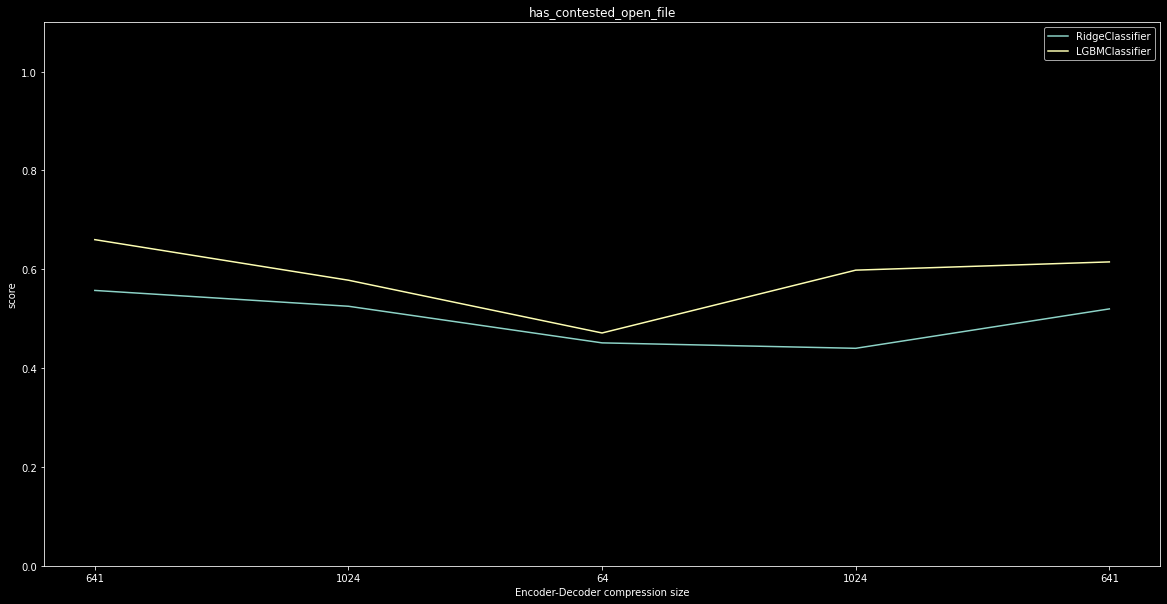

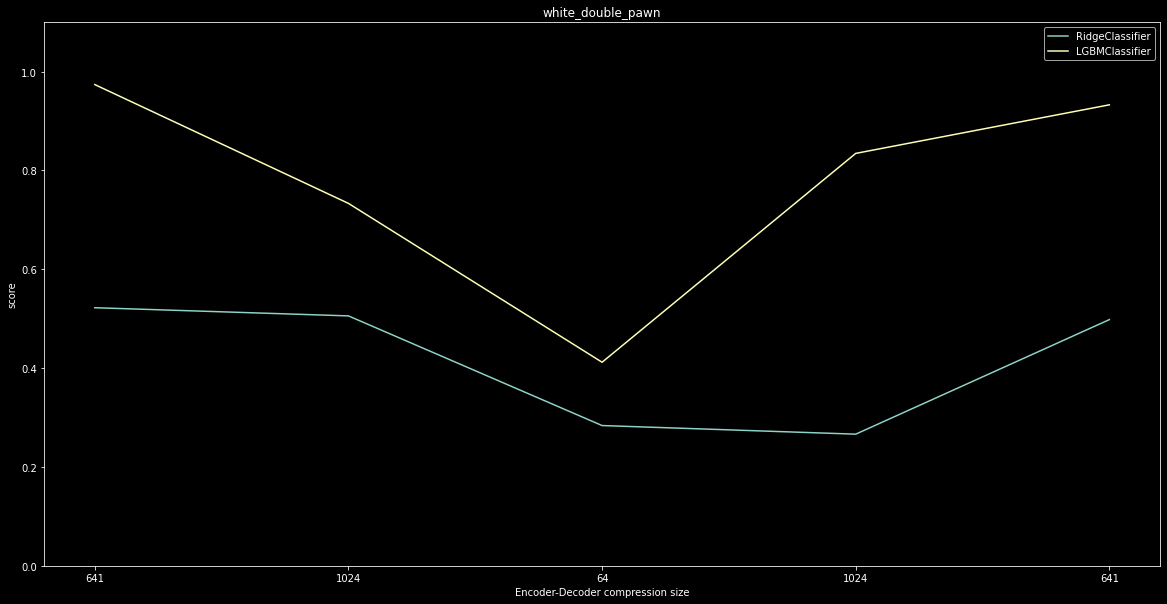

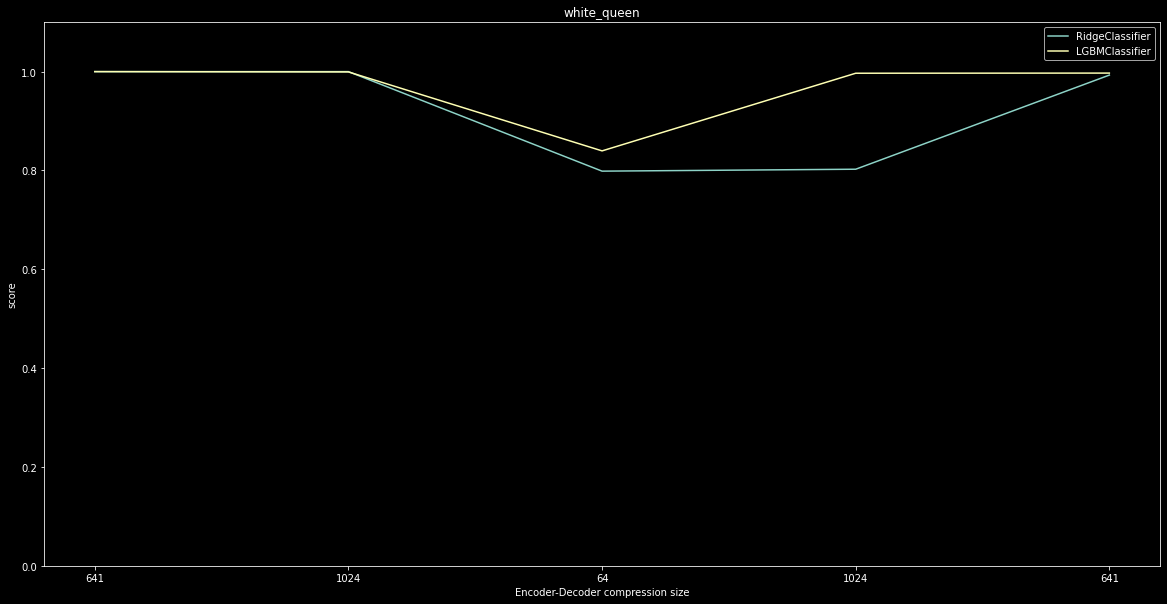

In [17]:

plot_results(df_results)

# Medium Model

In [18]:
from model_medium import DeepAutoencoder

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('models/model_BCE_medium_900.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
#model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
#model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()
df_activations.to_pickle('data/df_activations_medium.pkl')


150000it [01:38, 1523.62it/s]


In [19]:
df_activations = pd.read_pickle('data/df_activations_medium.pkl')

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    'encoder_2', 
    #'encoder_3', 
    #'decoder_0', 
    'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

target_names = [
    'has_contested_open_file',
    'white_double_pawn', 
    'white_queen'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)

df_results.to_pickle('data/df_results_medium.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_2, y: white_queen, model_name: .RidgeClassifier
X: decoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: decoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: decoder_1, y: white_queen, model_name: .RidgeClassifier
X: deco

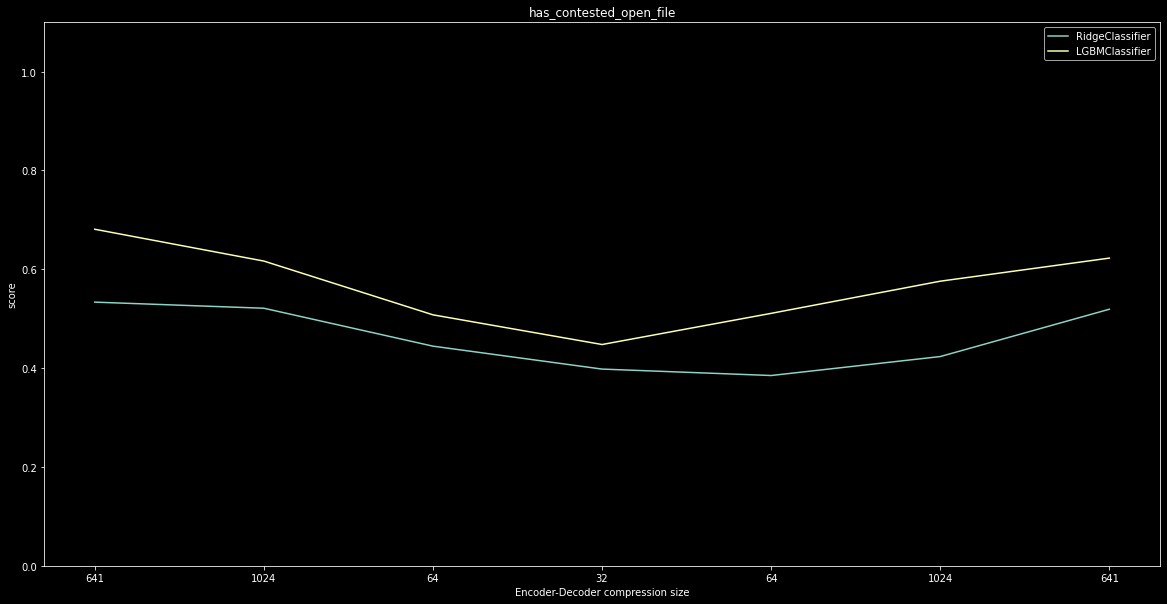

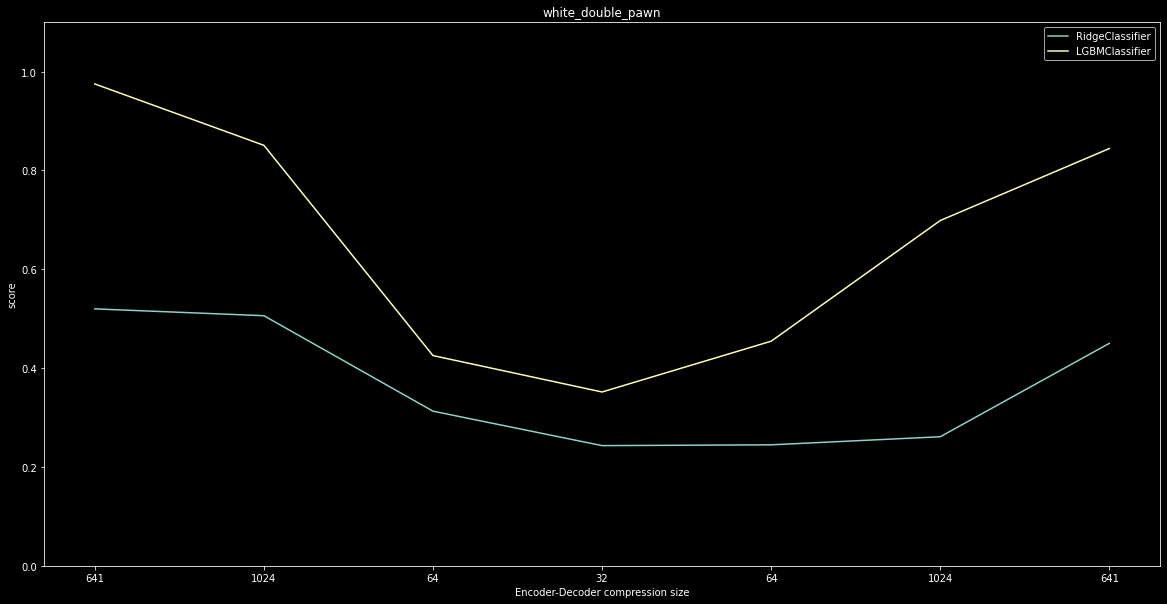

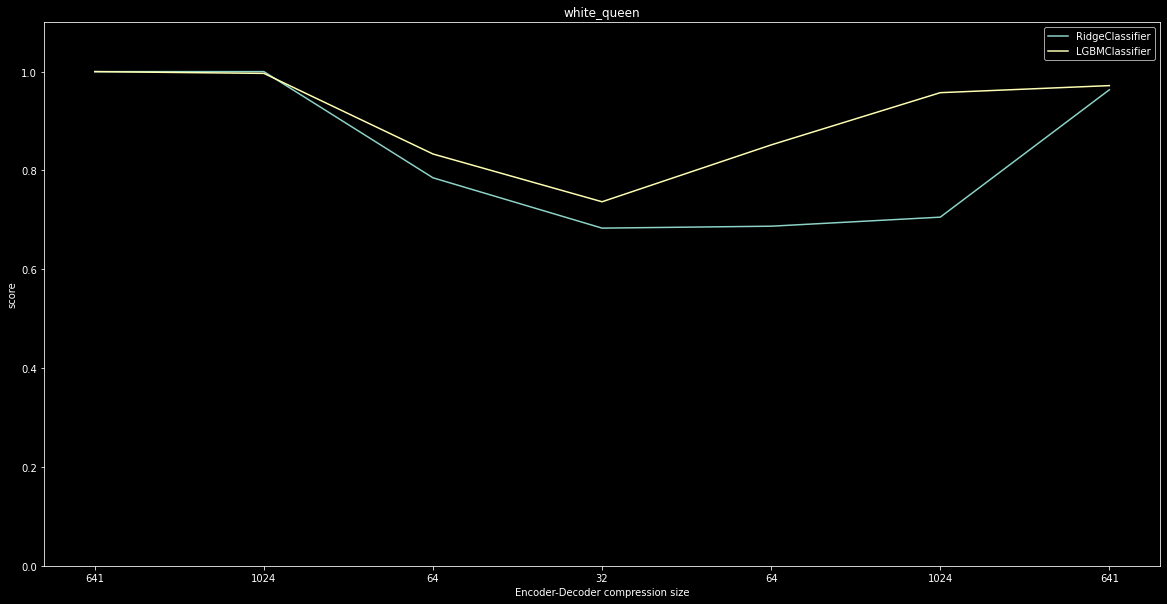

In [20]:

plot_results(df_results)

# Large Model

In [21]:
from model import DeepAutoencoder

model = DeepAutoencoder(input_size = 641)
model.load_state_dict(torch.load('models/model_BCE_700.pt'))



activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = input[0].detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

df_activations = get_activations(model, df)
df_activations.head()

df_activations.to_pickle('data/df_activations_large.pkl')


150000it [01:52, 1331.78it/s]


In [22]:
df_activations = pd.read_pickle('data/df_activations_large.pkl')

test_size = 0.33
metric = classification_cost

verbose = False

undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [
    RidgeClassifier(), 
    LGBMClassifier()
    ]

input_names = [
    'input_encoder_0', 
    'encoder_0', 
    'encoder_1', 
    'encoder_2', 
    'encoder_3', 
    'decoder_0', 
    'decoder_1', 
    'decoder_2',
    'decoder_3'
    ]

target_names = [
    'has_contested_open_file',
    'white_double_pawn', 
    'white_queen'
    ]

df_results = train_concept_models(concept_models, input_names, target_names, df_activations, df, undersample, test_size, metric, verbose = verbose)

df_results.to_pickle('data/df_results_large.pkl')

X: input_encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: input_encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: input_encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_0, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_0, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_0, y: white_queen, model_name: .RidgeClassifier
X: encoder_1, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_1, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_1, y: white_queen, model_name: .RidgeClassifier
X: encoder_2, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_2, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_2, y: white_queen, model_name: .RidgeClassifier
X: encoder_3, y: has_contested_open_file, model_name: .RidgeClassifier
X: encoder_3, y: white_double_pawn, model_name: .RidgeClassifier
X: encoder_3, y: white_queen, model_name: .RidgeClassifier
X: deco

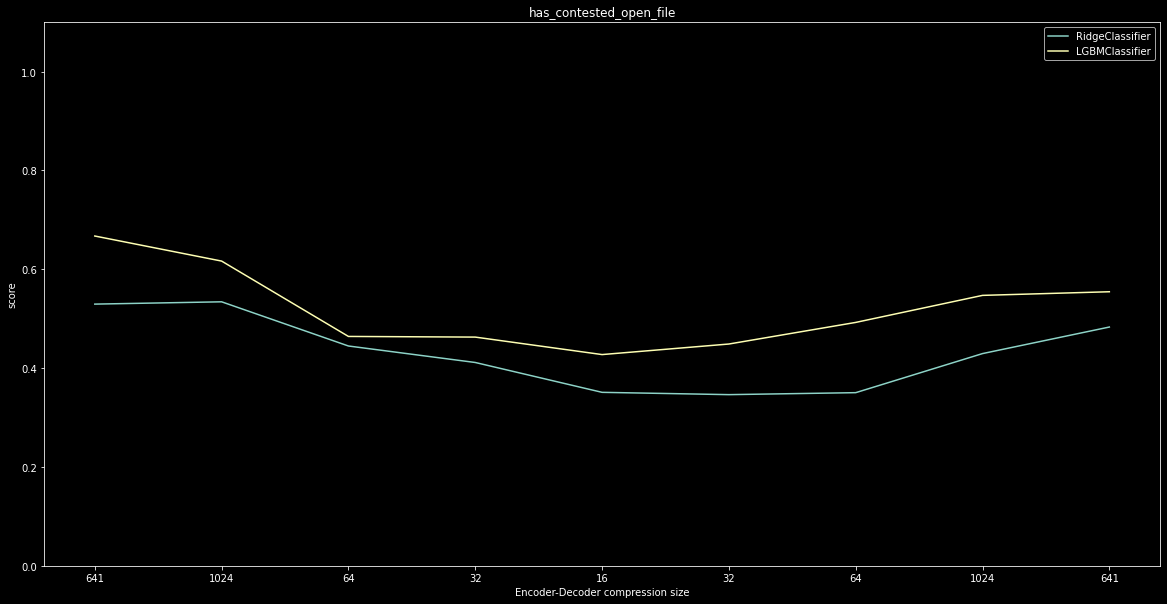

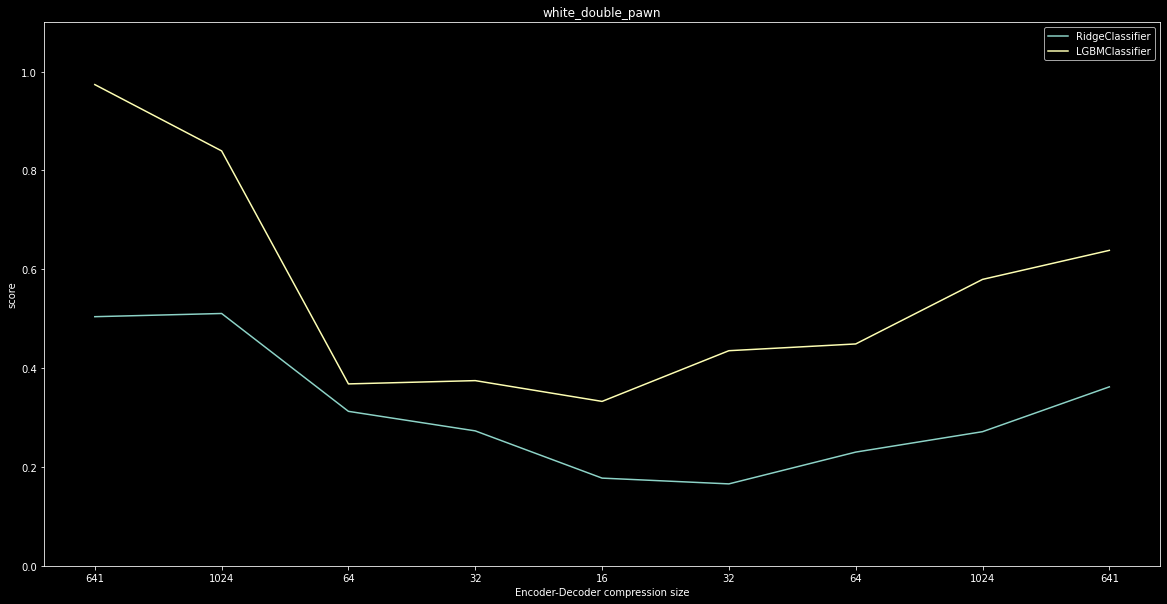

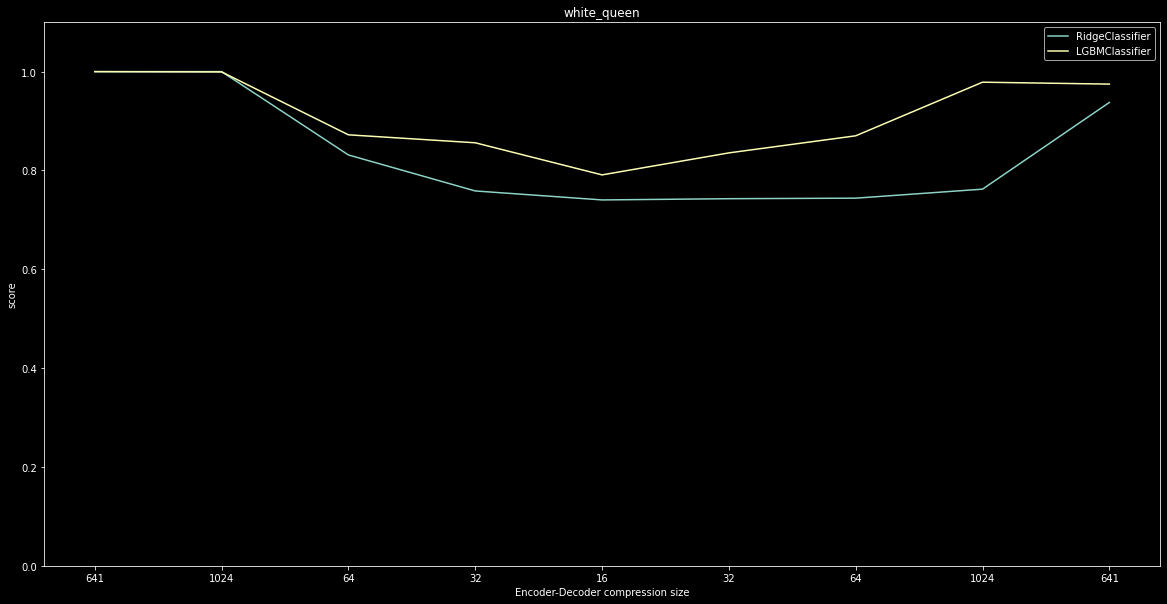

In [23]:
plot_results(df_results)